<a href="https://colab.research.google.com/github/eatanga-git/stockPriceAssocationWithNews/blob/main/Erick_Atanga_ISH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finding Association Between a Stock's Price and News Directly Related to Company of Said Stock

This is a program that displays data for popular stocks - more spefically, their stock prices over time - and that *scrapes the web* for articles corresponding to time periods where the stock price underwent a sudden and stark change. This is meant to investigate whether there is an association between the publicity/news of the stock, and the actual stock price (i.e. does negative or positive news about a company negatively or positvely influence the stock price? Or is there little association).

### The tools being used

Pandas (to help display data easily):
https://pandas.pydata.org/docs/index.html

Pandas Data-Reader (to get stock info easily): 
https://pandas-datareader.readthedocs.io/en/latest/

Beautiful Soup (to scrape the web for articles): 
https://realpython.com/beautiful-soup-web-scraper-python/

Numpy (to find calculations such as standard deviation, average, etc.)
https://numpy.org/


For this project, we use the *closing* price of a stock: this is because generally, news for a stock can come out pre-market or in the early hours market when its open, and thus it is better to find the final price of the stock at the end of the trading day. 

First, we will begin with a preliminary step by step run through of what we will do in order to achieve this end, using selected data from Apple as an example. Then we'll make a more generalized version of the code later on and test it with other stocks.

(Note: When running each block of code in this preliminary sectino, try to only run once. For some reason, when I run the code twice, what's in the output doubles for some reason. If it needs to be rerun, it is best to start over the whole thing.)



#Preliminary Trial


##Plot Data
We import the aforementioned libraries.

Then, we'll look at a moment in time when Apple's stock jumped. We'll use July 28th 2020 to August 6th 2020, and plot it

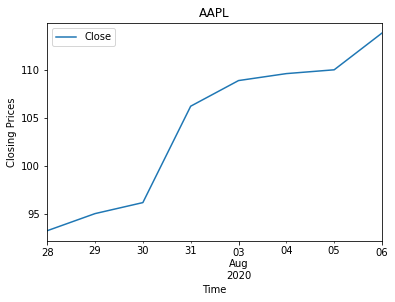

In [23]:
import pandas as pd 
#!pip install pandas-datareader
from pandas_datareader import data 

#Web Scraping
from bs4 import BeautifulSoup
import requests
import urllib.request

#Used to render graphs in notebook
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt #Plotting library
from datetime import datetime #datetime for timeseries support
import math

symbol = 'AAPL'
data_source='yahoo'
year1, year2 = 2020, 2020
month1, month2 = 7, 8
day1, day2 = 28, 6

start = datetime(2020, 7, 28)
end = datetime(2020, 8, 6)

# b. Generate plot of the data
drApplePlot = data.DataReader(symbol, data_source, start, end)['Close']
drApplePlot.plot(title='AAPL', legend=True, xlabel='Time', ylabel='Closing Prices')
 





We see the graph above. We notice that from the 30th of July to the 3rd of August, we saw a very high jump. We then want to investigate what happened during this time by scraping the web.

First, we'll create a list for stock prices, and a list for dates, for future reference

In [24]:
draf = data.DataReader(symbol, data_source, start, end)['Close']
drAF = pd.DataFrame(draf) 

appleclosePriceList = drAF['Close'].tolist()
applecloseDateList = drAF['Close'].keys().tolist() 
#drClosePD = drAF[['Close']]
#drClosePD.head(10)

print(applecloseDateList)


[Timestamp('2020-07-28 00:00:00'), Timestamp('2020-07-29 00:00:00'), Timestamp('2020-07-30 00:00:00'), Timestamp('2020-07-31 00:00:00'), Timestamp('2020-08-03 00:00:00'), Timestamp('2020-08-04 00:00:00'), Timestamp('2020-08-05 00:00:00'), Timestamp('2020-08-06 00:00:00')]


##Collect slopes from plot
We'll make a list of slopes and a list of stock jumps. 

Each day-to-day stock price change is essentially a slope (y is the stock price, x is the day). We use slopes to measure changes since, on a "typical" day, the stock price won't jump dramatically (or, the slope won't be so high or so low.)

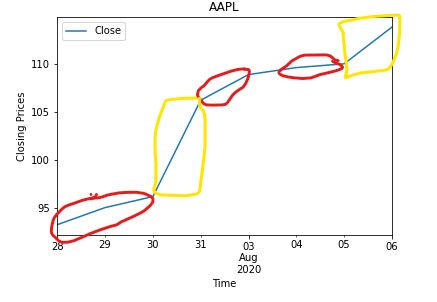

We can collect the slopes that make up the plot, then determine which slopes are outliers. Then put that into the stock jumps list.


We'll also print out the price list.

In [25]:
slopesList=[]
stockJumpsList = [] 

print(appleclosePriceList)


[93.25250244140625, 95.04000091552734, 96.19000244140625, 106.26000213623047, 108.9375, 109.66500091552734, 110.0625, 113.90249633789062]


Slope equation

In [26]:
for i in appleclosePriceList:
  if appleclosePriceList.index(i) < (len(appleclosePriceList)-1):
    #Normally, the equation of a slope is y2-y1/x2-x1. But because we are going day by day (and since markets are closed on the weekends for typical stocks),
    #the x2-x1 will always end up being 1. So we only calculate the y2-y1.
    slope = (appleclosePriceList[appleclosePriceList.index(i)+1] - i)
    slopesList.append(slope)  
    print(slope)
 

print(slopesList)


1.7874984741210938
1.1500015258789062
10.069999694824219
2.6774978637695312
0.7275009155273438
0.39749908447265625
3.839996337890625
[1.7874984741210938, 1.1500015258789062, 10.069999694824219, 2.6774978637695312, 0.7275009155273438, 0.39749908447265625, 3.839996337890625]


The plot shown above is reflected by the output shown here: most of the slopes are around 1-3 or so. We'll see that below.

Pull out outliers or extreme periods from slopelist (this is to help show areas where the stock price suddenly jumped or declined)

In [27]:
print("Standard Deviation of Stock Slopes:", np.std(slopesList))
print("Average of Stock Slopes:", np.average(slopesList))
print("Median of Stock Slopes:", np.median(slopesList))

#The median slope is 1.788. In other words, the typical increase of a stock price per day is usually just going to be over $1.5 dollars.
#As a result, we'll use the dates where the stock price is at least 1 standard deviations above or below the mean to use for articles.

for i in slopesList:
  if ((i > np.std(slopesList)) or (i < - np.std(slopesList))):
    stockJumpsList.append(i)

print(stockJumpsList)

Standard Deviation of Stock Slopes: 3.1077532986929715
Average of Stock Slopes: 2.9499991280691966
Median of Stock Slopes: 1.7874984741210938
[10.069999694824219, 3.839996337890625]


##Getting dates of slopes
Now, with our outliers, we go and find the corresponding dates.

We will backtrack to find the index of the outliers in the slopesList. Then use those indexes to find the dates in the applecloseDateList.

In [28]:
indexList = []
for i in stockJumpsList:
  indexList.append(slopesList.index(i))

print(indexList)

[2, 6]


Using the indexes, we append the dates with the corresponding indeces (and the following indeces to get the next date) and put them in a tuple that we pass into a list.

In [29]:
dateQueryList =[]
for i in indexList:
  dateQueryList.append((applecloseDateList[i], applecloseDateList[i+1]))

print(dateQueryList) 
print((dateQueryList[1][1]))


[(Timestamp('2020-07-30 00:00:00'), Timestamp('2020-07-31 00:00:00')), (Timestamp('2020-08-05 00:00:00'), Timestamp('2020-08-06 00:00:00'))]
2020-08-06 00:00:00


##Convert the date tuples to tuples of strings

This converts the list of tuples to a list of string tuples, so we can then subscript them into the query later on.

In [30]:

def convertDateTupleListToStrings(dateTupleList):
  strDateTupleList = []
  for i in (dateTupleList):
    date1 = (str(i[0]))
    date2 = (str(i[1]))
    dateTuple = (date1, date2)
    strDateTupleList.append(dateTuple)
  return strDateTupleList
     
convertDateTupleListToStrings(dateQueryList)   

print(convertDateTupleListToStrings(dateQueryList))
ex = convertDateTupleListToStrings(dateQueryList)
print(ex[0])
print(ex[0][0])

#return a tuple

[('2020-07-30 00:00:00', '2020-07-31 00:00:00'), ('2020-08-05 00:00:00', '2020-08-06 00:00:00')]
('2020-07-30 00:00:00', '2020-07-31 00:00:00')
2020-07-30 00:00:00


We then use this method to convert an element of a tuple into a string in "yyyy, mm, dd" format that can be easily inserted into the query. For this example, we will just use the first element (column) in the first tuple (or row). (This will be index [0][0] of the tuple.)

In [31]:
convertedStringDateList = convertDateTupleListToStrings(dateQueryList)



def getYMDstr(dateStrTupleList, row, column):
  date1 = dateStrTupleList[row][column]
  year = date1[0:4]
  month = date1[5:7]
  day = date1[8:10]
  return(year, month, day)


 

##Query

With our methods complete, we can now insert the dates into a query like so. This is for Apple during July 30th and 31st.

(Our query is a simple google search: We can get a gist of the overall "situation" by looking at some 20 or so articles around the web at a glance - namely, article titles and their descriptions. There is no need to scrape each particular website, as the overall gist and "mood" of the article can be seen by looking at the title and meta description.)

https://google.com/search?q=Apple+after:2020-07-30+before:2020-07-31&num=20
<!DOCTYPE html>
<html lang="en">
 <head>
  <meta charset="utf-8"/>
  <meta content="/images/branding/googleg/1x/googleg_standard_color_128dp.png" itemprop="image"/>
  <title>
   Apple after:2020-07-30 before:2020-07-31 - Google Search
  </title>
  <script nonce="rk3rXObKAZB6k3Rn3CuWhA==">
   (function(){
document.documentElement.addEventListener("submit",function(b){var a;if(a=b.target){var c=a.getAttribute("data-submitfalse");a="1"==c||"q"==c&&!a.elements.q.value?!0:!1}else a=!1;a&&(b.preventDefault(),b.stopPropagation())},!0);document.documentElement.addEventListener("click",function(b){var a;a:{for(a=b.target;a&&a!=document.documentElement;a=a.parentElement)if("A"==a.tagName){a="1"==a.getAttribute("data-nohref");break a}a=!1}a&&b.preventDefault()},!0);}).call(this);(function(){
var a=window.performance;window.start=Date.now();a:{var b=window;if(a){var c=a.timing;if(c){var d=c.navigationStart,f=c.responseStar
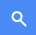

In [32]:
year1 = getYMDstr(convertedStringDateList, 0, 0)[0]
month1 = getYMDstr(convertedStringDateList, 0, 0)[1]
day30 = getYMDstr(convertedStringDateList, 0, 0)[2]

year2 = getYMDstr(convertedStringDateList, 0, 1)[0]
month2 = getYMDstr(convertedStringDateList, 0, 1)[1]
day31 = getYMDstr(convertedStringDateList, 0, 1)[2]

#url = "https://google.com/search?q=Apple+after:2020-07-28+before:2020-08-06&num=20"
url = "https://google.com/search?q=Apple+after:"+ year1 + "-" + month1 + "-" + day30 + "+before:" + year2 + "-" + month2 + "-" + day31 + "&num=20"
response =requests.get(url)
if not response.status_code==200 :
    print("request not successful")
else:
    print(url)

results_page = BeautifulSoup(response.content, 'lxml')
print (results_page.prettify())


##Extracting Articles 

We can then find all with the following tag and class that pulls up the link to each article, and the corresponding title, along with other information.

---



In [52]:
key_data=results_page.find_all('div', class_='ZINbbc xpd O9g5cc uUPGi')


# print the data type for the kv_data object

#print(key_data)
#print(type(key_data))
print(key_data[0])

<div class="ZINbbc xpd O9g5cc uUPGi"><div class="kCrYT"><a href="/url?q=https://www.apple.com/newsroom/2020/07/apple-reports-third-quarter-results/&amp;sa=U&amp;ved=2ahUKEwjFlIjix9PwAhU6CjQIHalsBEoQFjAAegQIDRAB&amp;usg=AOvVaw2Vp1c2ZO3-SEn6ufEQNTym"><h3 class="zBAuLc"><div class="BNeawe vvjwJb AP7Wnd">Apple Reports Third Quarter Results - Apple</div></h3><div class="BNeawe UPmit AP7Wnd">www.apple.com › newsroom › 2020/07 › apple-reports-third-quarter-results</div></a></div><div class="x54gtf"></div><div class="kCrYT"><div><div class="BNeawe s3v9rd AP7Wnd"><div><div><div class="BNeawe s3v9rd AP7Wnd"><span class="r0bn4c rQMQod">Jul 30, 2020</span><span class="r0bn4c rQMQod"> · </span>Apple reported its third quarter financial results for the fiscal year after the market close on Thursday, July 30, 2020.</div></div></div></div></div></div></div>


We can extract a title and meta-description that can give us a quick glance of what the article is about.

In [53]:
# extract the label 
Title = key_data[0].find('div', class_='BNeawe vvjwJb AP7Wnd').get_text()

Link = key_data[0].find('div', class_='kCrYT').get_text()

# extract the value
Info = key_data[0].find('div', class_='BNeawe s3v9rd AP7Wnd').get_text()

# print the results
print(Title)
print(Link)
print(Info)


Apple Reports Third Quarter Results - Apple
Apple Reports Third Quarter Results - Applewww.apple.com › newsroom › 2020/07 › apple-reports-third-quarter-results
Jul 30, 2020 · Apple reported its third quarter financial results for the fiscal year after the market close on Thursday, July 30, 2020.


To make things simpler, we can instead just pull up 20 article titles, as including the link and meta-description not only may make the program run slower, but will actually be redundant in this exercise. (20 is the parameter we set in the search query. We use about 20, as more than that may lead to some results that are less relevant.)

In [49]:
key_data=results_page.find_all('div', class_='BNeawe vvjwJb AP7Wnd')
for i in (key_data):
  print(i.get_text())




Apple Reports Third Quarter Results - Apple
Apple Gift Card - Apple
Apple (AAPL) earnings Q3 2020 - CNBC
Apple's revenues defy expectations and store closures | Financial ...
Documents show Apple gave Amazon special treatment to get Prime ...
Apple reports strong Mac and iPad sales in record-breaking Q3 ...
Apple beats on earnings and announces stock split, sending shares ...
Take a Look Inside Apple's New Retail Store in Bangkok - MacRumors
Apple earnings: Apple crushes Q3 expectations, announces 4-1 ...
Apple Q3 2020 results: Everything up – Six Colors
Apple announces fiscal Q3 2020 earnings: revenue of $59.7 billion ...
Apple Earnings Surge Behind Stimulus and Remote Work - WSJ
Apple's iPhone sales grew despite coronavirus, but iPhone 5G will ...
Telegram hits out at Apple's App Store 'tax' in latest EU antitrust ...
Apple's next iPhones to miss September launch; delayed several ...
Apple Kicks US Office Return Back to 2021, CEO Tim Cook Says ...
Apple (APPL) Shares Jump, iPhone Sma

Scanning through the list of 20 articles, we see information includes Apple's Earnings several times. ("Apple delivers blowout earnings" and "Apple crushes Q3 earnings".) This obviously implies that Apple's earnings reports may be the reason for the result. For our first trial, the news about the specific stock does have some association with the stock movement. The very positive news of Apple's earnings matches its increased stock price for that time period.

#Putting it all together in a few methods

We'll try to test this with the second date - but first, we'll condense what we've done into a few methods to reduce the bloat.

We'll have 3 helper methods, and 1 "main" method.

The helper methods will be:

**plotStock()**

**getRefinedYMDstr()**

**googleStock()**

And the main method will be:

**webScrapeStock()**


This is our revised "plotStock()" method. It will take a stock, starting time period, and ending time period as paramaters, and display a plot while also returning lists that consist of the time and stock prices respectively.

In [36]:
 def plotStock(stockSymbol, startYear, startMonth, startDay, endYear, endMonth, endDay): 
  data_source='yahoo'

  start = datetime(startYear, startMonth, startDay)
  end = datetime(endYear, endMonth, endDay)

  #Generates Plot
  drPlot = data.DataReader(stockSymbol, data_source, start, end)[['Close']]
  drPlot.plot(title= stockSymbol +' Plot for ' + str(startMonth) + '/' + str(startDay) + '/' + str(startYear) + ' to ' + str(endMonth) + '/' + str(endDay) + '/' + str(endYear), legend=True, xlabel='Time', ylabel='Closing Prices')
  
  drAF = pd.DataFrame(drPlot) 
  drAF.head()

  closePriceList = drAF['Close'].tolist()
  closeDateList = drAF['Close'].keys().tolist() 

  returnList = [closePriceList, closeDateList]
  return returnList



Helper method. Refined yyyy,mm,dd method that takes a single year-month-date item from a tuple and slices the year, month, and data out of it so it can easily fit into the query.

In [37]:
def getRefinedYMDstr(dateStrTupleList):
  date1 = dateStrTupleList
  year = date1[0:4]
  month = date1[5:7]
  day = date1[8:10]
  return(year, month, day)


Second helper method. Takes the sliced out year, month, and day from a datetime and places it into the query. Returns about 20 google results. 

In [38]:
def googleStock(dateStrTupleList, searchTerm, numberOfResults):

  startYear = getRefinedYMDstr(dateStrTupleList[0])[0]
  startMonth = getRefinedYMDstr(dateStrTupleList[0])[1]
  startDay = getRefinedYMDstr(dateStrTupleList[0])[2]
  endYear = getRefinedYMDstr(dateStrTupleList[1])[0]
  endMonth = getRefinedYMDstr(dateStrTupleList[1])[1]
  endDay = getRefinedYMDstr(dateStrTupleList[1])[2] 

  url = "https://google.com/search?q=" + searchTerm + "+after:"+ startYear + "-" + startMonth + "-" + startDay + "+before:" + endYear + "-" + endMonth + "-" + endDay + "&num="+ str(numberOfResults)
  response =requests.get(url)
  if not response.status_code==200 :
      print("request not successful")
  else:
      print(url)

  results_page = BeautifulSoup(response.content, 'lxml') 

  key_data=results_page.find_all('div', class_='BNeawe vvjwJb AP7Wnd')
  for i in (key_data):
    print(i.get_text())



The big, completed method.

In [74]:
def webScrapeStock(stockSymbol, startYear, startMonth, startDay, endYear, endMonth, endDay, numberOfResults):

  #This is so that when we search for news about the company, we are typing in the actual company name rather than the stock symbol
  stockSymbolDict = {'AAPL': 'Apple', 
                     'MSFT': 'Microsoft',
                     'TSLA':'Tesla',
                     'SNE':'Sony',
                     'FB':'Facebook',
                     'NIO':'Nio',
                     'NFLX':'Netflix',
                     'DIS':'Disney',
                     'GE':'General Electric',
                     'BYND':'Beyond Meat',
                     'F':'Ford',
                     'BAC':'Bank of America',
                     'SBUX':'Starbucks'
                     
                     }

  closePriceList = plotStock(stockSymbol, startYear, startMonth, startDay, endYear, endMonth, endDay)[0]
  closeDateList = plotStock(stockSymbol, startYear, startMonth, startDay, endYear, endMonth, endDay)[1]


  slopesList=[]
  stockJumpsList = [] 

  #Get slopes from graph, day-to-day
  for i in closePriceList:
    if closePriceList.index(i) < (len(closePriceList)-1):    
      slope = (closePriceList[closePriceList.index(i)+1] - i)
      slopesList.append(slope)  

  #Append outlier slopes (which represents steep increases or steep declines in stock) to slope list
  for i in slopesList:
    if ((i > np.std(slopesList)) or (i < - np.std(slopesList))):
      stockJumpsList.append(i)

  #Get the indexes of the slopes in the original slopes list so we can find the dates
  indexList = []
  for i in stockJumpsList:
    indexList.append(slopesList.index(i))

  #Get matching dates, append to a datequeryList
  dateQueryList =[]
  for i in indexList:
    dateQueryList.append((closeDateList[i], closeDateList[i+1]))
  
  #Using our method we made before, convert the dates to a string format
  convertedStringDateList = convertDateTupleListToStrings(dateQueryList)

  

  #Take the list date tuples, and parse them into a yyyy, mm, dd format and run a query with them, each
  print("Total Search Results")
  for i in convertedStringDateList:
    if(stockSymbol in stockSymbolDict):
      print("\n", "Results for", stockSymbolDict[stockSymbol], "from", i[0][0:-8],"through", i[1][0:-8])
      googleStock(i, stockSymbolDict[stockSymbol], numberOfResults)
    else:
      print("\n", "Results for", stockSymbol, "from", i[0][0:-8],"through", i[1][0:-8])
      googleStock(i, stockSymbol, numberOfResults)
 


###Running it with Apple

Now, we will run the method with the whole thing.

Total Search Results

 Results for Apple from 2020-07-30  through 2020-07-31 
https://google.com/search?q=Apple+after:2020-07-30+before:2020-07-31&num=20
Apple Reports Third Quarter Results - Apple
Apple Gift Card - Apple
Apple (AAPL) earnings Q3 2020 - CNBC
Apple's revenues defy expectations and store closures | Financial ...
Documents show Apple gave Amazon special treatment to get Prime ...
Apple reports strong Mac and iPad sales in record-breaking Q3 ...
Apple beats on earnings and announces stock split, sending shares ...
Take a Look Inside Apple's New Retail Store in Bangkok - MacRumors
Apple earnings: Apple crushes Q3 expectations, announces 4-1 ...
Apple Q3 2020 results: Everything up – Six Colors
Apple announces fiscal Q3 2020 earnings: revenue of $59.7 billion ...
Apple Earnings Surge Behind Stimulus and Remote Work - WSJ
Apple's iPhone sales grew despite coronavirus, but iPhone 5G will ...
Telegram hits out at Apple's App Store 'tax' in latest EU antitrust ...
Apple's next i

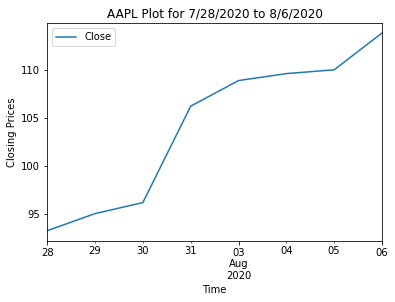

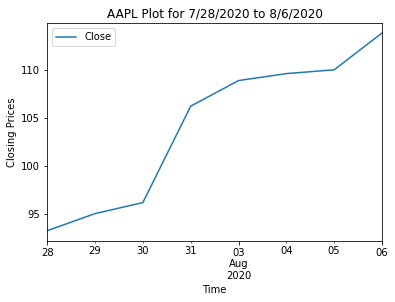

In [40]:
webScrapeStock('AAPL', 2020, 7, 28, 2020, 8, 6, 20)

As we see, for the second stock jump, there is a noticeable difference; the results seem a little less consistent. We see some info about Apple competing with Microsoft's xCloud - more specifcally Microsoft's action towards Apple. We do see some positive news though - such as Apple teasing information about its App Store for its 10th anneversary. However, this is actually fitting, as on the plot above, the second stock jump (August 5-6) was noticeably smaller than the stock jump from July 30th to the 31st.

###Running it with Microsoft

We'll now do the same with Microsoft.

First, we'll use the plotStock method independently and plug in random dates just to display a plot so we can see any noticeable changes in Microsoft's stock price. We'll choose a time period of say July 20th, 2020, to say, August 20th, 2020.

[[211.60000610351562,
  208.75,
  211.75,
  202.5399932861328,
  201.3000030517578,
  203.85000610351562,
  202.02000427246094,
  204.05999755859375,
  203.89999389648438,
  205.00999450683594,
  216.5399932861328,
  213.2899932861328,
  212.94000244140625,
  216.35000610351562,
  212.47999572753906,
  208.25,
  203.3800048828125,
  209.19000244140625,
  208.6999969482422,
  208.89999389648438,
  210.27999877929688,
  211.49000549316406,
  209.6999969482422,
  214.5800018310547],
 [Timestamp('2020-07-20 00:00:00'),
  Timestamp('2020-07-21 00:00:00'),
  Timestamp('2020-07-22 00:00:00'),
  Timestamp('2020-07-23 00:00:00'),
  Timestamp('2020-07-24 00:00:00'),
  Timestamp('2020-07-27 00:00:00'),
  Timestamp('2020-07-28 00:00:00'),
  Timestamp('2020-07-29 00:00:00'),
  Timestamp('2020-07-30 00:00:00'),
  Timestamp('2020-07-31 00:00:00'),
  Timestamp('2020-08-03 00:00:00'),
  Timestamp('2020-08-04 00:00:00'),
  Timestamp('2020-08-05 00:00:00'),
  Timestamp('2020-08-06 00:00:00'),
  Timestamp

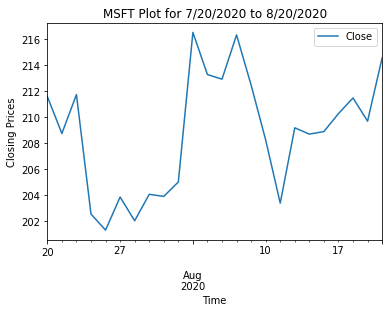

In [41]:
plotStock('MSFT', 2020, 7, 20, 2020, 8, 20)

This plot shows a lot of variety in Micrisoft's stock price. It is noticeably up and down, compared to Apple. It will be interesting to see what happened to Microsoft during this time...

Next we'll run the webscrape method to see what happened with Microsoft directly.

Total Search Results

 Results for Microsoft from 2020-07-22  through 2020-07-23 
https://google.com/search?q=Microsoft+after:2020-07-22+before:2020-07-23&num=20
FY20 Q4 - Press Releases - Investor Relations - Microsoft
Microsoft cloud strength drives fourth quarter results - Stories
Microsoft reports $38 billion in Q4 2020 revenue: Azure up 47 ...
Microsoft just had a stellar three months thanks to Azure, Surface ...
Microsoft (MSFT) earnings Q4 2020 - CNBC
Why I'm leaving Microsoft - YouTube
Microsoft Inspire 2020: CEO Satya Nadella - YouTube
Microsoft Earnings Beat Q4 Estimates, But MSFT Stock Falls ...
Multitasking improvements in Windows 10 and Microsoft Edge ...
Microsoft Shares Drop as Azure Cloud-Services Sales Slow ...
Microsoft revenue up 13% to $38B as stay-at-home orders boost ...
Microsoft (MSFT) Overdue for Intermediate Correction - Investopedia
Microsoft cloud flagship posts first growth under 50%; bookings ...
Microsoft reports record revenue to wrap up a record-breakin

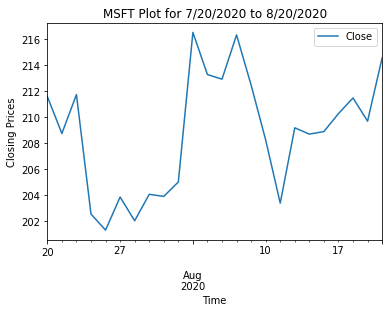

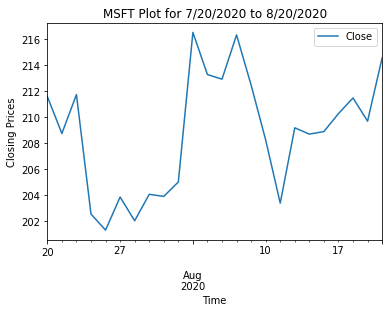

In [42]:
webScrapeStock('MSFT', 2020, 7, 20, 2020, 8, 20, 20)

Just like magic, we get search results from both positive and negative swings in the stock price.

Off the bat, the query appears to accurately reflect both positive and negative swings in the stock price over time (or as we defined it, when the outlier slope is larger than one standard deviation above the mean or smaller than one standard deviation below the mean). 

The first set of results (from July 22nd to July 23rd) has a mix of positive and negative news. However, the negative news dealt with *legal issues* - Slack filing an anti-trust complaint. Gauging whether legal matters drasitcally influence stock prices is beyond the scope of this project and is a topic for another day, but on a casual level, it is safe to assume that legal issues are *definitely* important. 

The period from July 31st to August 3rd has a slight dip; but given that this dip is a small swing in the middle of a stark jump up from the week before, it is still worth checking articles from the whole period. Anyway, during this time, Microsoft was rumored to have purchased the popular social media platform TikTok. This is a no brainer for stock prices.

The next two periods are interesting: Bill Gates calling the TikTok acquisition a "poisoned chalice" seems to be the only negative news, as Microsoft's stock plummetted. This is relevant, coming from the founder and former CEO Bill Gates, who is still connected to Microsoft.


Let's move on to Tesla for another case example.



###Tesla

Total Search Results

 Results for Tesla from 2020-12-17  through 2020-12-18 
https://google.com/search?q=Tesla+after:2020-12-17+before:2020-12-18&num=20
5 Companies Owned by Tesla - Investopedia
Tesla shares jump to record high ahead of S&P 500 debut | Reuters
Sleeping in My Tesla! - YouTube
I wanted a Tesla. Then I found out the company doesn't hire enough ...
Tesla debt edges close to investment-grade rating at S&P ...
Elon Musk should apologize for mocking gender pronouns, says HRC
Tesla Model S review: Still the king of the hill? | CAR Magazine
Tesla Joins the S&P 500: Five Things to Watch - WSJ
Why Tesla Stock Jumped on Thursday | The Motley Fool
Watch Out, Elon Musk. These EV Startups Are Trying To Take On ...
Tesla Upgraded by S&P After Cash Levels Soar to Record High ...
Tesla Tardiness Is Echoed in Mattel's Cybertruck Toy Delay ...
Wall Street braces for trading surge as Tesla enters S&P 500
Tesla Joins the S&P 500. What to Know. | Barron's
Toyota Plays Tesla Spoiler: Sees a 

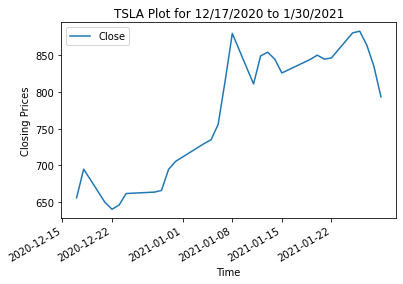

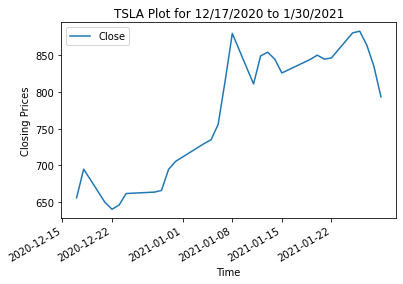

In [43]:
webScrapeStock('TSLA', 2020, 12, 17, 2021, 1, 30, 20)

Tesla stock is interesting to analyze because for much of its rises (during early January), much of the news articles were "meta", for a lack of a better term. Much of the articles seemed to be about how successful it is doing, and how it may rise. 

Interestingly enough, it's decline at the end of January seemed to have articles that, well, did not *predominantly* feature negative news. Only a handful of articles in our 20 results seem to reference Tesla's earnings disappointment. However, missing earnings is always enough to cause alarm.

Another fall it suffered from January 11th to the 12th is interesting to look at, as no articles are distinctly negative. Much of them describe a sales competition with Nio. Additionally, we see a few more 'meta' articles that are aware of Tesla's stock randomly dipping, such as "TSLA Streak Ends Despite New High Price Target + Tesla AI Day ..." and "Tesla Stock Dips, but Not for the Reason You'd Expect". This strange self awareness posits that simple happenstances regarding the company that happen to make the news itself aren't the only factors responsible for the stock decline. There may be other external factors not strictly tied to the news. 

This is why Tesla is interesting to analyze.


###Running Facebook

Lastly, we'll look at Facebook

Total Search Results

 Results for Facebook from 2021-01-05  through 2021-01-06 
https://google.com/search?q=Facebook+after:2021-01-05+before:2021-01-06&num=20
Introducing the New Pages Experience - About Facebook
Our Response to the Violence in Washington - About Facebook
This Might Be What Finally Makes Me Quit Facebook in 2021. It's an ...
Edit Your Ad | Facebook Business Help Center
Close an Ad Account in Ads Manager | Facebook Business Help ...
Troubleshoot Unrecognized Activity on Your Ad Account | Facebook ...
Create disclaimers and link ad accounts for ads about ... - Facebook
• Facebook by the Numbers (2021): Stats, Demographics & Fun Facts
Facebook's foolish attack on Apple | ZDNet
Apple's upcoming iPhone privacy feature puts Facebook and Snap ...
Facebook to Announce Fourth Quarter and Full Year 2020 Results
Facebook to restart political ad ban after Georgia Senate runoffs ...
Facebook revamps Pages with cleaner design, hides likes - CNET
Facebook Pages Redesigned, 5 New Fea

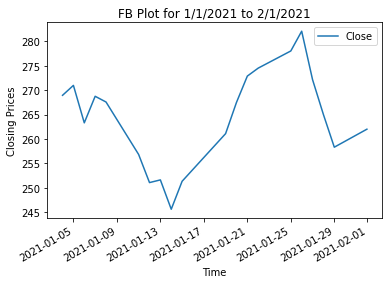

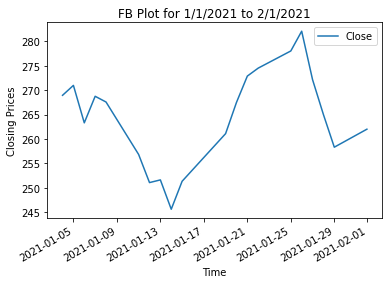

In [44]:
webScrapeStock('FB', 2021, 1, 1, 2021, 2, 1, 20)

Facebook shows a clearer association between the articles and price movements. The massive plunge from January 8th to January 11th correlated with news about Facebook banning Trump, and pro-Trump content. This would obviously alienate users of the platform that support Trump, and thus the stock price did fall in response.

It's subsequent rise during the middle of January is less obvious. There were some articles discussing how Facebook would ban ads promoting guns and military gear. Additionally, some negative articles in regards to Facebook's privacy issues. However, the stock rose. This could engender further outside research as to the state of the market to determine why Facebook would rise.

It's later decline in the the last week of Janaury appears to coincide with Mark Zuckerberg's comments on Facebook facing "uncertainty" in 2021, Facebook continuing to lose users in the USA and Canada, and perhaps most importantly, legal issues and controversy surrounding Facebook: more specifically, Apple's new requirements that apps on their platform would not be able to require users to accept intrusive tracking, ads, and data collection just to use an app. Facebook - whose revenue relies heavily on such activity - publicly rallied against it, even purchasing newspaper ads in the process. They claimed that it would hurt small businesses, but the price of Facebook's stock still went down, thus showing doubt over Facebook's intentions.

#Conclusion

By looking at some of these popular stocks, we see that there definitely is an association between news articles regarding the company, and the company's stock. But even without a complicated mathematical analysis to determine the exact correlation between the prices and articles, simply looking at Tesla and Facebook shows that this association is not 1 to 1: anyone that trades stocks regularly would know this, as often times, stocks can inexplicably fall or rise without a clear cause. Tesla seemed to rise *because* it was rising one point, for example.

Other times, they may have a cause, but it may be bigger than the company itself. For instance, many popular stocks did decline following the capitol riots, before subsequently rising again a day or so later. And as we saw with Facebook, 
Overall, stock prices changed without any clear reason. The news about Facebook in the media during that time did not particularly lean positive or negative, yet the stock still jumped - and this was well after the effects of the capital riot on the stock market had been reversed.

All in all, there is an association with a company's news, and its corresponding stock price, but there are other factors, from time to time. This is a subject that definitely warrants more research in the future.